In this notebook I am going to create a few different dataframes that consist of patient data, potentially different sizes of image pixel arrays, etc.


In [1]:
import glob, pylab, pandas as pd
import pydicom, numpy as np
import pandas_profiling as pp

/anaconda3/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use(BACKEND)


In [2]:
# I am going to incorporate the rest of the target data (x, y, width, height) even though currently I am only trying to see if the person has pneumonia or not.
df = pd.read_csv('../data/stage_1_train_labels.csv')
# Example of a "Normal" person
print(df.iloc[0])

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 0, dtype: object


In [3]:
# Example of a person with pneumonia
print(df.iloc[4])

patientId    00436515-870c-4b36-a041-de91049b9ab4
x                                             264
y                                             152
width                                         213
height                                        379
Target                                          1
Name: 4, dtype: object


0    20025
1     8964
Name: Target, dtype: int64

In [4]:
# Retrieving the data out of the .dcm file
patientId = df['patientId'][0]
dcm_file = '../data/stage_1_train_images/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)

print(dcm_data)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

The data retrieved from the `.dcm` is important. Not only does it have the pixel array that we want to test against but it also has things like Age, Sex, and others that we might want to filter over.

In [5]:
# Creating a DataFrame of all of the information minus the pictures in the .dcm files
all_info_cols = ['patientId', 'specificCharacterSet', 'modality', 'conversionType', 'sex', 'age', 'viewPosition', 'photometricInterpretation']

In [6]:
all_info = []
for i in df['patientId']:
    dcm_file = '../data/stage_1_train_images/%s.dcm' % i
    dcm_data = pydicom.read_file(dcm_file)
    all_info.append([i, dcm_data.SpecificCharacterSet, dcm_data.Modality, dcm_data.ConversionType, dcm_data.PatientSex, dcm_data.PatientAge, dcm_data.ViewPosition, dcm_data.PhotometricInterpretation])


# Looking at the different unique values for the potentially interesting datapoints

#print(dcm_data.SpecificCharacterSet.unique())

In [7]:
patient_data = pd.DataFrame(data=all_info, columns=all_info_cols)
patient_data.head()

,patientId,specificCharacterSet,modality,conversionType,sex,age,viewPosition,photometricInterpretation
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,ISO_IR 100,CR,WSD,F,51,PA,MONOCHROME2
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,ISO_IR 100,CR,WSD,F,48,PA,MONOCHROME2
2,00322d4d-1c29-4943-afc9-b6754be640eb,ISO_IR 100,CR,WSD,M,19,AP,MONOCHROME2
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,ISO_IR 100,CR,WSD,M,28,PA,MONOCHROME2
4,00436515-870c-4b36-a041-de91049b9ab4,ISO_IR 100,CR,WSD,F,32,AP,MONOCHROME2


In [8]:
all_info_cols

['patientId',
 'specificCharacterSet',
 'modality',
 'conversionType',
 'sex',
 'age',
 'viewPosition',
 'photometricInterpretation']

In [9]:
columns = all_info_cols
columns.remove('patientId')
columns.remove('age')
columns.append('age')

In [10]:
for col in columns:
    print(col+": "+str(patient_data[col].value_counts()))
    print('\n\n\n')
    

specificCharacterSet: ISO_IR 100    28989
Name: specificCharacterSet, dtype: int64




modality: CR    28989
Name: modality, dtype: int64




conversionType: WSD    28989
Name: conversionType, dtype: int64




sex: M    16491
F    12498
Name: sex, dtype: int64




viewPosition: AP    14628
PA    14361
Name: viewPosition, dtype: int64




photometricInterpretation: MONOCHROME2    28989
Name: photometricInterpretation, dtype: int64




age: 58     894
56     827
52     764
55     724
54     683
59     682
57     666
53     656
49     631
46     630
40     621
51     611
45     609
60     592
61     572
43     564
50     556
48     553
44     540
47     538
65     520
64     516
62     509
63     507
66     490
34     489
67     481
42     461
31     448
32     442
      ... 
12     100
11      95
78      84
6       79
81      78
79      68
80      57
8       52
7       42
83      39
82      38
5       26
86      25
3       25
2       23
87      20
4       19
90      19
85      15
84     

Potential things to look into: viewPosition, sex, age


In [15]:
# I want to see the difference between a PA and an AP xray
def show_image(patientId):
    dcm_file = '../data/stage_1_train_images/%s.dcm' % patientId
    dcm_data = pydicom.read_file(dcm_file)
    im = dcm_data.pixel_array
    pylab.imshow(im, cmap=pylab.cm.gist_gray)
    pylab.axis('off')

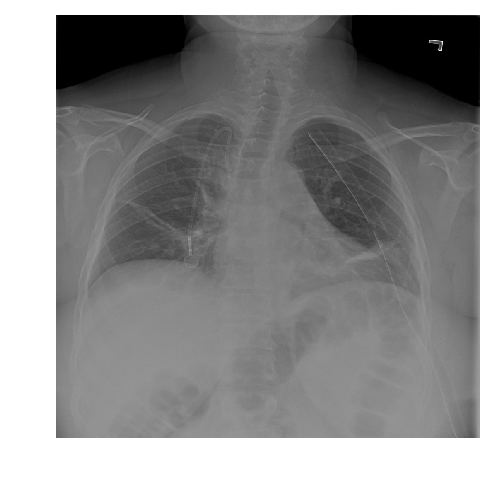

In [16]:
pa_patient = patient_data[patient_data['viewPosition']=='PA'].iloc[1]['patientId']
show_image(pa_patient)

In [ ]:
ap_patient = patient_data[patient_data['viewPosition']=='AP'].iloc[6]['patientId']
show_image(ap_patient)

In [18]:
set(patient_data['age'].unique()) - set([str(i) for i in range(1,101)]) 


{'148', '150', '151', '153', '155'}

The oldest living person was 122 years old and died in 1997 in France. I'm thinking these xrays with the patient's age as over 100 aren't good data and are likely mislabeled. Since the data isn't good I'm deleting everything where age is over 100

In [19]:
# Change age into an int so that I can use > and <
patient_data['age'] = patient_data['age'].astype(int)

In [20]:
patient_data.dtypes


patientId                    object
specificCharacterSet         object
modality                     object
conversionType               object
sex                          object
age                           int64
viewPosition                 object
photometricInterpretation    object
dtype: object

In [24]:
pp.ProfileReport(patient_data)

Number of variables,8
Number of observations,28989
Total Missing (%),0.0%
Total size in memory,1.8 MiB
Average record size in memory,64.0 B
Numeric,1
Categorical,3
Boolean,0
Date,0
Text (Unique),0
Rejected,4


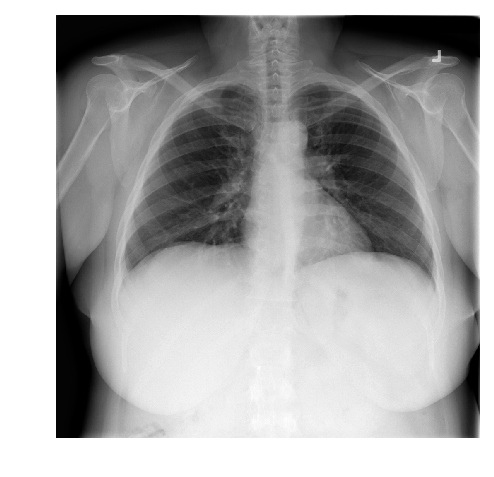

In [22]:
test = patient_data[patient_data['age'] ==155].iloc[0]['patientId']
show_image(test)

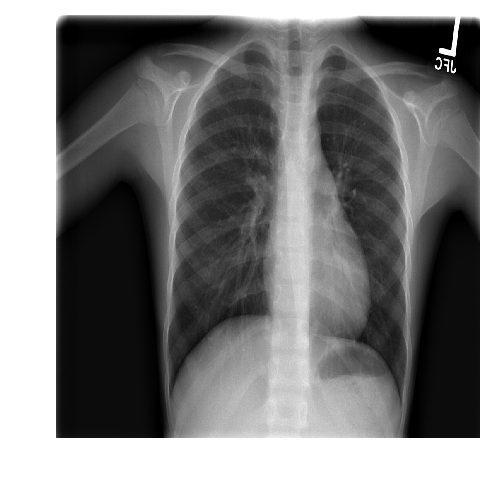

In [23]:
child = patient_data[patient_data['age']==7].iloc[0]['patientId']
show_image(child)

Kids have different bone structures to adults (obviously) so I'm going to only train/test off of adult data. I'm not sure when people generally finish growing / get close enough to finished so I'm going to use the generic 18.

What I want to do at this point
- Change age into an int in the df. 
- Take out the very old/young people. 
- Create a model that uses only Male AP and train/test. See if there's a difference.
    - Do the same for Female AP
    - Same for PA
- Is there any more EDA that can be done?


In [25]:
feats_i_dont_need = ['conversionType', 'modality', 'photometricInterpretation', 'specificCharacterSet']

In [26]:
patient_data = patient_data.drop(columns=feats_i_dont_need)

In [27]:
# Getting rid of the overly ambitiously aged patient data
patient_data = patient_data[patient_data['age']<=100]

In [28]:
adult_patient_data = patient_data[patient_data['age']>=18]

In [29]:
adult_patient_data.columns

Index(['patientId', 'sex', 'age', 'viewPosition'], dtype='object')

In [30]:
male_adult_patient_data = adult_patient_data[adult_patient_data['sex']=='M']
male_adult_patient_data.head(1)

,patientId,sex,age,viewPosition
2,00322d4d-1c29-4943-afc9-b6754be640eb,M,19,AP


In [31]:
#Going to save this to see if the age / sex had any major effects
male_adult_patient_data.to_csv('../data/male_adult_patient_data.csv', index=False)

In [32]:
testing_save = pd.read_csv('../data/male_adult_patient_data.csv')
testing_save.head(1)

,patientId,sex,age,viewPosition
0,00322d4d-1c29-4943-afc9-b6754be640eb,M,19,AP


In [33]:
testing_save.dtypes

patientId       object
sex             object
age              int64
viewPosition    object
dtype: object

In [34]:
testing_save.duplicated().sum()

1763

In [40]:
testing_save[testing_save.duplicated()].sort_values('patientId').head()

,patientId,sex,age,viewPosition
5,00704310-78a8-4b38-8475-49f4573b2dbb,M,75,PA
10,00f08de1-517e-4652-a04f-d1dc9ee48593,M,58,AP
14,010ccb9f-6d46-4380-af11-84f87397a1b8,M,21,AP
17,012a5620-d082-4bb8-9b3b-e72d8938000c,M,60,AP
21,0174c4bb-28f5-41e3-a13f-a396badc18bd,M,23,AP


In [36]:
female_adult_patient_data = adult_patient_data[adult_patient_data['sex']=='F']
female_adult_patient_data.head(1)

,patientId,sex,age,viewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,F,51,PA


In [37]:
#Going to save this to see if the age / sex had any major effects
female_adult_patient_data.to_csv('../data/female_adult_patient_data.csv', index=False)

In [38]:
adult_patient_data.to_csv('../data/adult_patient_data.csv', index=False)

In [39]:
adult_patient_data.shape

(27537, 4)

In [41]:
target_df = pd.read_csv('../data/stage_1_detailed_class_info.csv')